# Project Name: Crime Data Analysis over the years in the states of USA
### Designed By:
    1. Manasi Joshi (netid - mbjoshi2)
    2. Shruti Deekshitula (nedit - shrutid4)

In [84]:
# Import required files
import pandas as pd
import numpy as np
import glob
import json
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, widgets, fixed
import matplotlib.image as mpimg
%matplotlib inline
from data_preprocessing import get_crime_score

Please note - "dataset_final.csv" is very large (1.5GB). This file cannot be uploaded to git. However, we have uploaded a sample file for reference of the fields and values present for the fields. 

We have processed the data into required dataframes for further analysis and saved them to .csv files which are later used in the analysis. These files can be downloaded and the chunks can be run on the viewer/user end.  

In [49]:
# Reads the final dataset that was created by data-pre_processing

df_data = pd.read_csv("dataset_final.csv")
df_data.tail()

incident_id  month_num  data_year state_abbr crime_against  age_num  \
62956029    121929614         10       2019         WV        Person       20   
62956030    111875588          4       2019         WV       Society       28   
62956031    119275455          9       2019         WV      Property       39   
62956032    112118964          5       2019         WV        Person       46   
62956033    121930527         11       2019         WV        Person       31   

         sex_code        weapon_name  \
62956029        M            Unarmed   
62956030        M            Unarmed   
62956031        M            Unarmed   
62956032        M            Unarmed   
62956033        M  Rifle (Automatic)   

                                          race_desc  
62956029                                      Asian  
62956030  Native Hawaiian or Other Pacific Islander  
62956031  Native Hawaiian or Other Pacific Islander  
62956032  Native Hawaiian or Other Pacific Islander  
62956033  Native Hawaiian or Other Pacific Islander

Reference sample_dataset_final.csv for reference of how the actual 1.5GB dataset_final.csv looks like and used for creating rest of the .csv used in hypothesis testing.

In [50]:
# Ouputs to a sample file for reference
sample_df = df_data.loc[:400000].copy()
sample_df.to_csv("final_datasets\sample_dataset_final.csv", index=False)

In [51]:
# Creating a dataframe to calculate total crimes across months for each state in the given years
month_crimes = df_data.groupby(['state_abbr','data_year','month_num'])['incident_id'].count()
month_crimes = month_crimes.reset_index()
month_crimes.rename(columns= {'data_year':'year','month_num':'month', 'incident_id':'total_crimes'}, inplace=True)

# Write to csv for reading it into the dataframe at a later point
month_crimes.to_csv("final_datasets\state_month_wise_crimes.csv", index= False)
month_crimes.head()

state_abbr  year  month  total_crimes
0         AL  2006      1           375
1         AL  2006      2           327
2         AL  2006      3           389
3         AL  2006      4           375
4         AL  2006      5           433

In [71]:
def holiday_or_non(group: pd.Series)-> str:
    """
    Returns string if the month is holiday or non-holiday
    """
    if group['month'] > 10 or group['month'] >= 12 :
        return "holiday"
    else:
        return "non-holiday"
    
# Apply the defined function with lambda to the dataframe and create a new column to check if the month is holiday/non-holiday   
month_crimes['holiday']= month_crimes.apply(lambda x : holiday_or_non(x), axis=1)

In [72]:
# Groups by holiday/non-holiday on the dataframe to calculate total_crimes in the two groups and pivots the table
holiday_df = month_crimes.groupby(['state_abbr','year','holiday'])['total_crimes'].sum().reset_index()
holi_update = holiday_df.pivot(index = ['state_abbr','year'] ,columns=['holiday'], values = ['total_crimes'])
holi_update = holi_update.droplevel(0, axis=1)
holi_update['total'] = holi_update['holiday'] + holi_update['non-holiday'] 
holi_update.rename(columns={'total_crimes':'crimes'}, inplace=True)

# Write to csv for reading it into the dataframe at a later point
holi_update.to_csv("final_datasets\holiday_months.csv")
holi_update.head()

holiday          holiday  non-holiday   total
state_abbr year                              
AL         2006    722.0       3917.0  4639.0
           2007    846.0       3916.0  4762.0
           2008    808.0       3821.0  4629.0
           2009    679.0       3691.0  4370.0
           2010    692.0       3460.0  4152.0

In [73]:
# Group by on crime against category to calculate total number of crimes in each category and pivots the table
crime_against_df = df_data.groupby(['state_abbr','data_year','crime_against'])['incident_id'].count().reset_index()
crime_against_df.rename(columns={'incident_id':'num_crimes','data_year':'year'}, inplace=True)
crime_against_df = crime_against_df.pivot(index = ['state_abbr','year'] ,columns=['crime_against'], values = ['num_crimes'])
crime_against_df = crime_against_df.droplevel(0, axis=1)

# Write to csv for reading it into the dataframe at a later point
crime_against_df.to_csv("final_datasets\crime_against.csv")
crime_against_df.head()

crime_against    Not a Crime  Person  Property  Society
state_abbr year                                        
AL         2006          NaN   782.0    3409.0    448.0
           2007          NaN   865.0    3524.0    373.0
           2008          NaN   867.0    3306.0    456.0
           2009          NaN   833.0    3008.0    529.0
           2010          NaN   848.0    2837.0    467.0

In [70]:
# Group by on crime against each race category to calculate total number of crimes in each race category and pivots the table
race_against_df = df_data.groupby(['data_year','state_abbr','race_desc'])['incident_id'].count().reset_index()
race_against_df.rename(columns={'incident_id':'num_crimes','data_year':'year'}, inplace=True)
race_against_df = race_against_df.pivot(index= [ 'state_abbr','year'], columns=['race_desc'], values = ['num_crimes'])
race_against_df = race_against_df.droplevel(0, axis = 1)

# Filters only the required columns and casts to integer
req_col = ['American Indian or Alaska Native', 'Asian', 'Black or African American', 'White']
race_against_df = race_against_df[req_col]
race_against_df.fillna(0, axis =1 , inplace = True)
race_against_df[req_col] = race_against_df[req_col].astype("int64")

# Calculates the total crimes in each year for each of the states present
total_crimes = df_data.groupby(['data_year','state_abbr'])['incident_id'].count().reset_index()
total_crimes.rename(columns={'incident_id':'total_crimes','data_year':'year'}, inplace=True)

# Merge the crimes against each race category and total crimes
race_total_df = pd.merge(race_against_df, total_crimes, how = 'inner', left_on=['year','state_abbr'], right_on=['year','state_abbr'], right_index=False)

# # Write to csv for reading it into the dataframe at a later point
race_total_df.to_csv("final_datasets/race_against.csv", index=False)
race_total_df.head()

year state_abbr  American Indian or Alaska Native  Asian  \
0  2006         AL                               932    892   
1  2007         AL                               922    917   
2  2008         AL                               889    908   
3  2009         AL                               792    789   
4  2010         AL                               734    771   

   Black or African American  White  total_crimes  
0                       1265   1542          4639  
1                       1346   1566          4762  
2                       1316   1506          4629  
3                       1203   1572          4370  
4                       1213   1428          4152

### All required files for hypothesis are generated. Below chucnks of code are available to run with the datasets present in the final_datasets folder. Can be used for further analysis and hypothesis

### Hypothesis 2 : Having the different political party at state and national level influences the number of crimes

H0: Number of crimes is higher in states having different ruling party at the state and center level as compared to if the states have same ruling party  


H1: Number of crimes is higher in states having same ruling party at the state and center level

In [2]:
# Reads the total crimes against each race for all the years
race_against_df = pd.read_csv("final_datasets/race_against.csv")
race_against_df.head()

year state_abbr  American Indian or Alaska Native  Asian  \
0  2006         AL                               932    892   
1  2007         AL                               922    917   
2  2008         AL                               889    908   
3  2009         AL                               792    789   
4  2010         AL                               734    771   

   Black or African American  White  total_crimes  
0                       1265   1542          4639  
1                       1346   1566          4762  
2                       1316   1506          4629  
3                       1203   1572          4370  
4                       1213   1428          4152

In [68]:
# Reads the states population in each year between 2008 - 2019 along with state_id
state_pop = pd.read_csv("final_datasets/state_pop.csv", index_col= 0)
state_pop['Total'] = state_abbr['Total'].astype("int64")

In [4]:
# Merge the files to have the total population and total crimes against race in one dataframe
state_race_df = pd.merge( race_against_df, state_pop, how = 'inner', left_on = ['state_abbr','year'], right_on = ['Code','Year'], right_index=False)
state_race_df.drop(columns = ['Code','Year','Total'], axis = 1, inplace=True)
state_race_df = state_race_df[['State','state_abbr','year','American Indian or Alaska Native','Asian','Black or African American','White','total_crimes']]
state_race_df.columns = state_race_df.columns.str.title()
state_race_df.head()

State State_Abbr  Year  American Indian Or Alaska Native  Asian  \
0  Alabama         AL  2008                               889    908   
1  Alabama         AL  2009                               792    789   
2  Alabama         AL  2010                               734    771   
3  Alabama         AL  2011                               769    742   
4  Alabama         AL  2012                               719    711   

   Black Or African American  White  Total_Crimes  
0                       1316   1506          4629  
1                       1203   1572          4370  
2                       1213   1428          4152  
3                       1234   1367          4123  
4                       1202   1395          4035

In [56]:
# Reads the election data for every election year with state wise elected party and central elected party
election_df = pd.read_excel("final_datasets/election.xlsx")
election_df.reset_index(inplace=True)
election_df.columns = election_df.columns.str.lower()

# Merge the election data with state wise crime against race data
election_race_df = pd.merge(state_race_df, election_df, how = 'inner', left_on=['State','Year'], right_on=['state','year'], right_index=False)
election_race_df.head()

State State_Abbr  Year  American Indian Or Alaska Native  Asian  \
0  Alabama         AL  2008                               889    908   
1  Alabama         AL  2009                               792    789   
2  Alabama         AL  2010                               734    771   
3  Alabama         AL  2011                               769    742   
4  Alabama         AL  2012                               719    711   

   Black Or African American  White  Total_Crimes  index    state  \
0                       1316   1506          4629      0  Alabama   
1                       1203   1572          4370     51  Alabama   
2                       1213   1428          4152    102  Alabama   
3                       1234   1367          4123    153  Alabama   
4                       1202   1395          4035    204  Alabama   

  elected_party_state  year elected_party_center  
0           Repulican  2008           Democratic  
1           Repulican  2009           Democratic  
2           Repulican  2010           Democratic  
3           Repulican  2011           Democratic  
4           Repulican  2012           Democratic

In [51]:
def plot_bar_state_election(year_df: pd.DataFrame, years: str):
    """
    Plots a dual axis graph for the dataframe with total crimes 
    :param year_df: dataframe for the selected years 
    :param years: string value for title of the plots
    """
    center = year_df['elected_party_center'].unique()[0]
    # cited reference - https://plotly.com/python/bar-charts/
 
    subfig = make_subplots(specs=[[{"secondary_y": True}]])
    fig = px.bar(year_df, x = 'State', y = 'Total_Crimes',  hover_name = 'elected_party_state',
            color = 'elected_party_state', color_discrete_sequence=px.colors.sequential.Viridis_r,
            title='States vs crime rate - Republican')

    fig2 = px.scatter(year_df_16, x = 'State', y = ['American Indian Or Alaska Native','Asian',
                                                    'White','Black Or African American'])
    fig2.update_traces(yaxis="y2")

    subfig.add_traces(fig.data + fig2.data)
    subfig.layout.xaxis.title="States"
    subfig.layout.yaxis.title="Total crimes from year " + years
    subfig.layout.yaxis2.title="Total crimes for each race category"
    subfig.update_yaxes(showgrid=False, zeroline=False)

    subfig.update_layout({
    "plot_bgcolor": "rgba(0, 0, 0, 0)",
    "paper_bgcolor": "rgba(0, 0, 0, 0)",
    "title_text": "State vs Crimes - Year " + years + " (Elected Center Party - " + center + " )"   
    })
    subfig.show()

In [52]:
def create_4year_df(df: pd.DataFrame, start_year: int) -> pd.DataFrame:
    """
    Returns a dataframe by filtering from the start year to consecutive 4 years where the elected party was same. Adds the
    total crime and crime against race for filtered years.
    :param df: dataframe created from main dataframe and filters the required years
    :start_year: integer value for start of the year
    """
    year_wise = df[(df['Year'] == start_year) | (election_race_df['Year'] == start_year+1) 
                                 | (election_race_df['Year'] == start_year+2) | (election_race_df['Year'] == start_year+3)]
    year_df = year_wise.groupby(['State','elected_party_state','elected_party_center'])[['American Indian Or Alaska Native','Asian','Black Or African American','White','Total_Crimes']].sum()
    
    year_df.reset_index(inplace=True)
    
    return year_df

In [53]:
# Dataframe and graph for consecutive years 2008 - 2011
df_08 = create_4year_df(election_race_df, 2008)
plot_bar_state_election(df_08, '2008 - 2011')

# Dataframe and graph for consecutive years 2012 - 2015
df_12 = create_4year_df(election_race_df, 2012)
plot_bar_state_election(df_12, '2012 - 2015')

# Dataframe and graph for consecutive years 2016 - 2019
df_16 = create_4year_df(election_race_df, 2016)
plot_bar_state_election(df_16, '2016 - 2019')


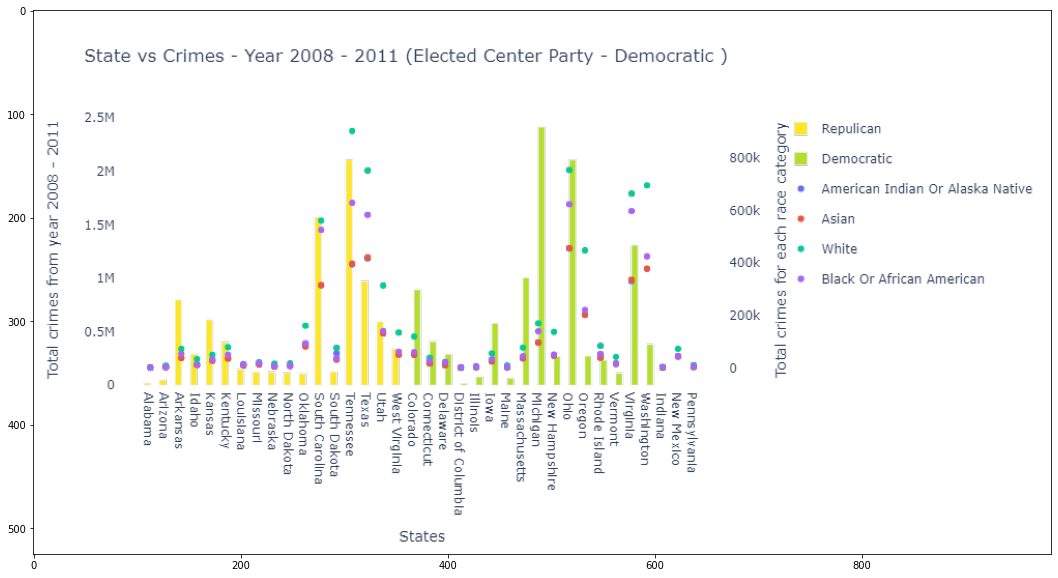

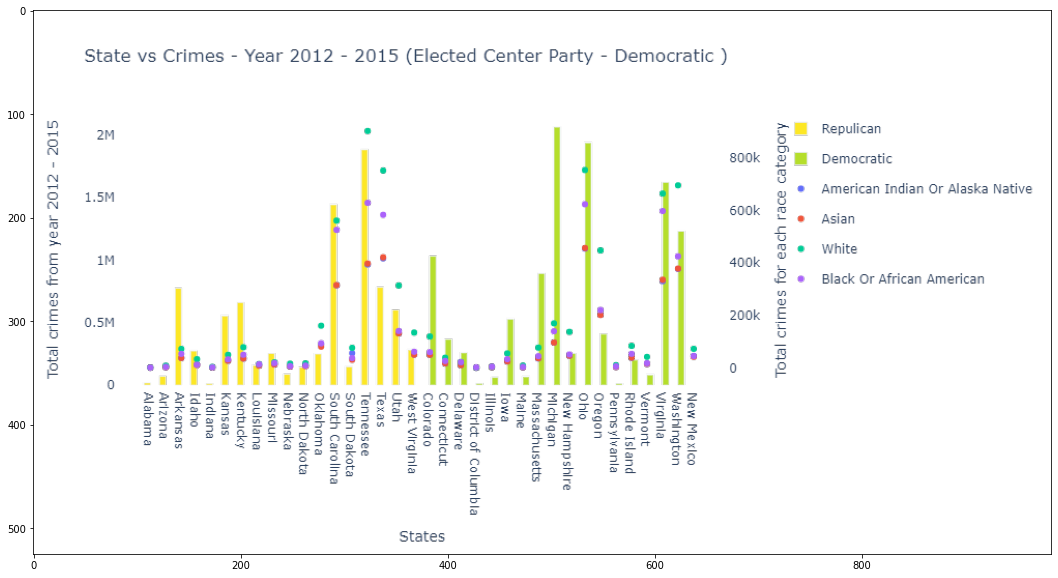

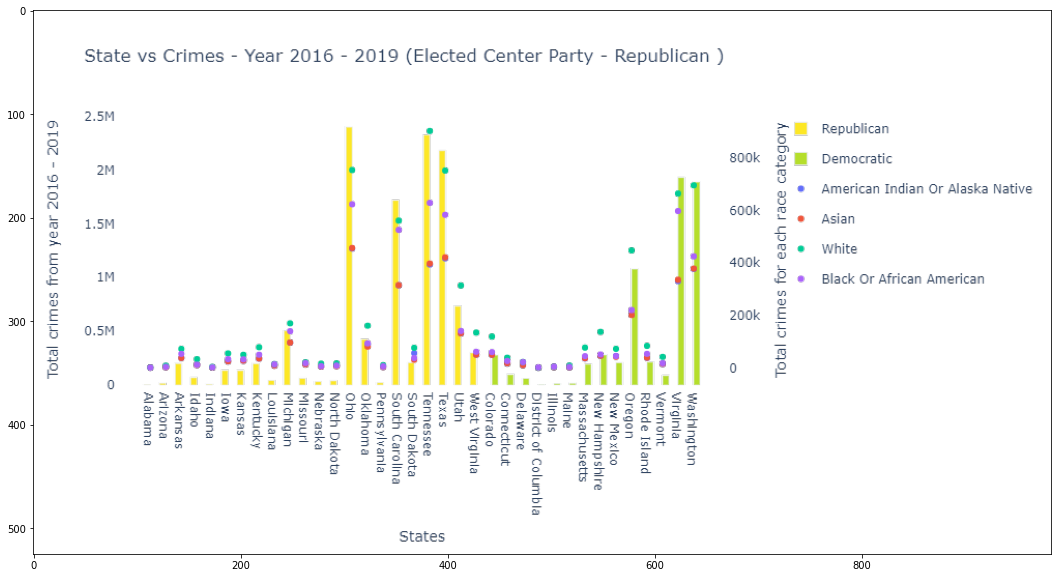

In [54]:
# Below is the reference image of what outputs after you run above cell for year 2016-2019 as an example. 

# Read Images
im = mpimg.imread('images\State vs Crime 2016-2019.png')

# Output Images
path = "images\State*"
files = glob.glob(path)

for file in files:
    im = mpimg.imread(file)
    plt.figure(figsize=(20,10))
    plt.imshow(im)


#### Based on the above visualizations. 
#### Null hypothesis H0 is rejected.

## Hypothesis 3 : Holiday season affects the number of crimes

H0: There is increase in number of crimes during holiday season (Positive lean) 

H1: The number of crimes do not increase during holiday season


In [15]:
# Reads the total crimes in all the months for each state for years between 2008 - 2019
df = pd.read_csv("final_datasets/state_month_wise_crimes.csv")
holiday_months  = df.groupby(['year','month'])['total_crimes'].sum()
holiday_months = holiday_months.reset_index()

In [18]:
def draw_graph(ax, df, year):
    """
    Plots line graph for the listed years in the given subplots 
    """
    dates = np.array(df["date"].tolist())
    returns = np.array(df["total_crimes"].tolist())

    doublediff = np.diff(np.sign(np.diff(returns)))
    peak_locations = np.where(doublediff == -2)[0] + 1

    doublediff2 = np.diff(np.sign(np.diff(-1*returns)))
    trough_locations = np.where(doublediff2 == -2)[0] + 1

    ax.plot(dates, returns, "-.")
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.set_ylim(200000,500000)
    ax.set_xlabel("Month-Year",fontsize=12)
    ax.set_ylabel("Number of crimes",fontsize=12)
    ax.set_title("US - Number of crimes across months in the year "+str(year), fontsize=14, fontweight='bold')
    ax.scatter(df.date.iloc[peak_locations], df.total_crimes.iloc[peak_locations], marker="o", color='tab:grey', s=100, label='Peaks')
    ax.scatter(df.date.iloc[trough_locations], df.total_crimes.iloc[trough_locations], marker="o", color='tab:grey', s=100, label='Troughs')

    p_len = len(peak_locations)
    t_len = len(trough_locations)

    if p_len > t_len:
        r = p_len - t_len
        for i in range(r):
            trough_locations = np.append(trough_locations,[trough_locations[-1]])

    elif t_len > p_len:
        r = t_len - p_len
        for i in range(r):
            peak_locations = np.append(peak_locations,[peak_locations[-1]])

    for t, p in zip(trough_locations, peak_locations):
        ax.text(df.date.iloc[p], df.total_crimes.iloc[p]+15, df.total_crimes.iloc[p], horizontalalignment='left', color='k')
        ax.text(df.date.iloc[t], df.total_crimes.iloc[t], df.total_crimes.iloc[t], horizontalalignment='left', color='k')

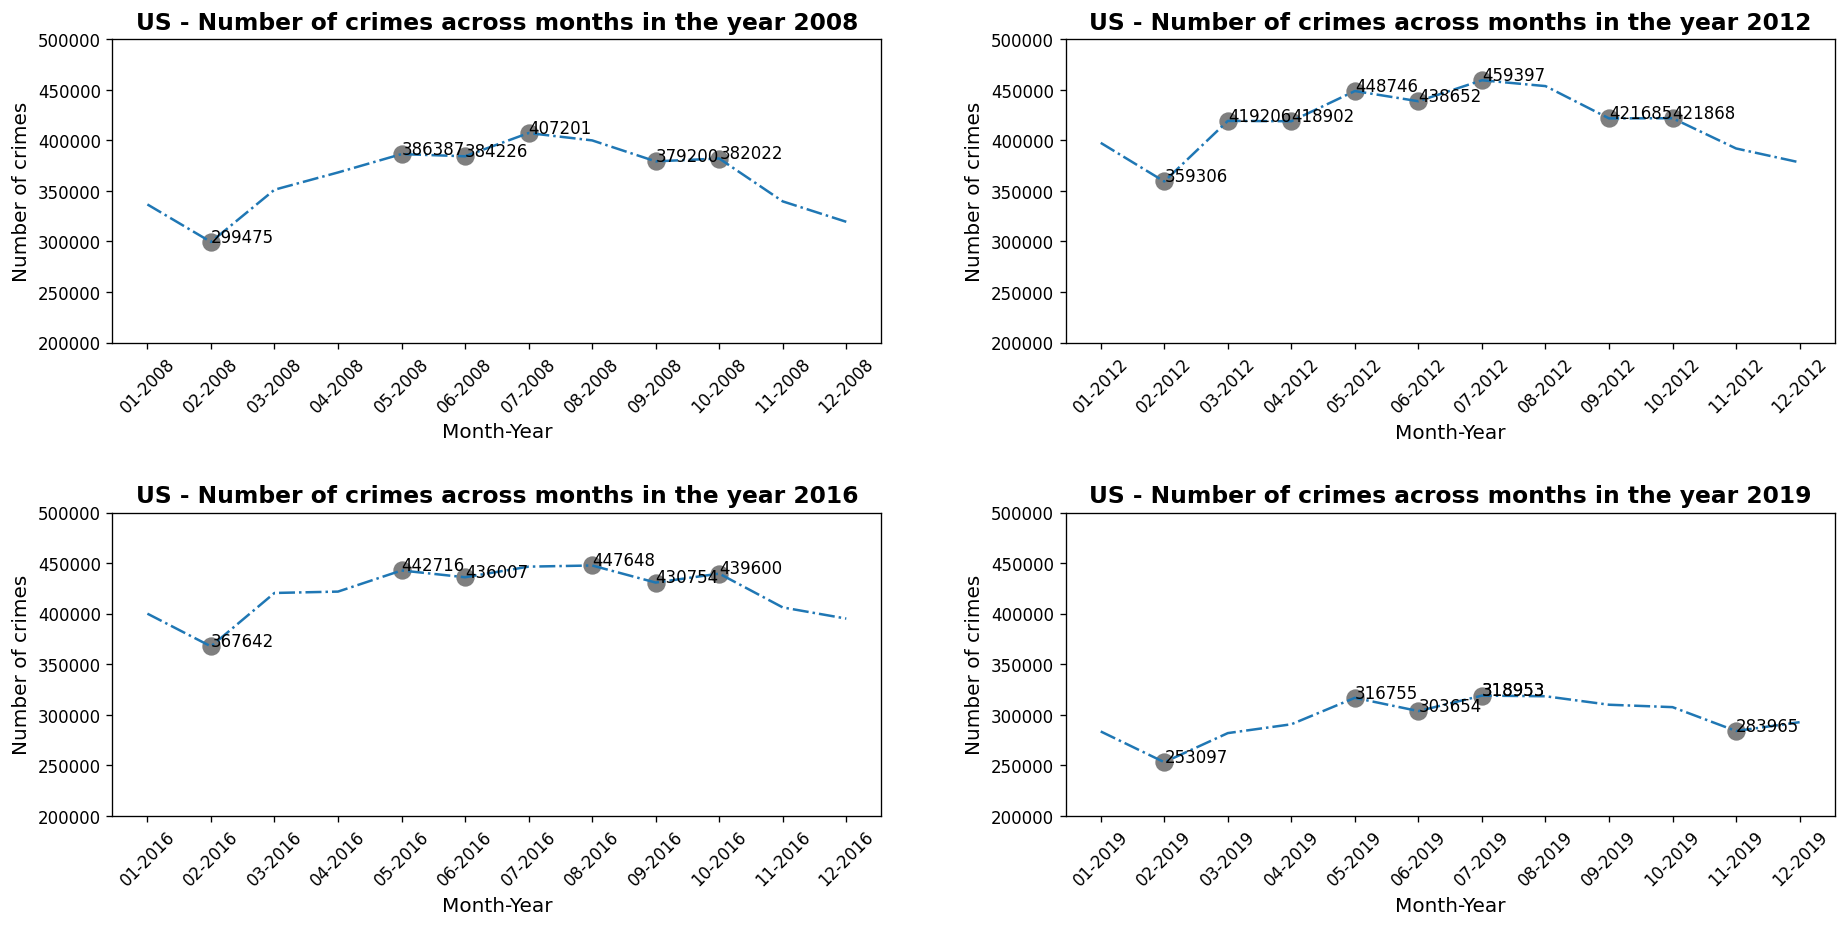

In [19]:
# Plotting graphs for years to visuzalize the crimes during every month of the year and determin if the crime number was higher 
# during holiday months (11, 12)

year_list  = [2008, 2012, 2016, 2019]

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(17,9), dpi= 120)

fig.tight_layout(pad=8.0)
axes = [ax0, ax1, ax2, ax3]

for i in range(len(year_list)):
    year_df = holiday_months[holiday_months['year'] == year_list[i]].copy()
    year_df['date'] = year_df['month'].map(str)+ '-' +year_df['year'].map(str)
    year_df['date'] = pd.to_datetime(year_df['date'], format='%m-%Y').dt.strftime('%m-%Y')
    draw_graph(axes[i], year_df, year_list[i])

plt.show()


### Based on the above visualizations
### Hypothesis 3 : Proved False - Crime rates during holiday season are not higher as compared to non-holiday season    


### Further analyzing the crime score for US states in the user input years. Reference from the paper  https://www.alarms.org/holiday-crime-rankings-by-state/

In [87]:
# Read the data for total crimes during holiday and non-holiday season
h_df = pd.read_csv("holiday_months.csv")
h_df.head()

state_abbr  year  holiday  non-holiday   total
0         AL  2006    722.0       3917.0  4639.0
1         AL  2007    846.0       3916.0  4762.0
2         AL  2008    808.0       3821.0  4629.0
3         AL  2009    679.0       3691.0  4370.0
4         AL  2010    692.0       3460.0  4152.0

In [88]:
# Read the data for total crimes against person, property, society and not a crime category
c_df = pd.read_csv("crime_against.csv")
c_df.head()

state_abbr  year  Not a Crime  Person  Property  Society
0         AL  2006          NaN   782.0    3409.0    448.0
1         AL  2007          NaN   865.0    3524.0    373.0
2         AL  2008          NaN   867.0    3306.0    456.0
3         AL  2009          NaN   833.0    3008.0    529.0
4         AL  2010          NaN   848.0    2837.0    467.0

In [89]:
# Merge the state-wise population and number of crimes during holiday, non-holiday, total crimes,crime agaisnt for years between 2008 -2019
final_df = pd.merge( h_df, state_pop, how = 'inner', left_on = ['state_abbr','year'], right_on = ['Code','Year'], right_index=False)
final_df = pd.merge( c_df, final_df, how = 'inner', left_on = ['state_abbr','year'], right_on = ['Code','Year'], right_index=False)
final_df = final_df[['State','Code','Year','Total','holiday','non-holiday','Property','Person','Society','Not a Crime','total']]
final_df.head()
final_df = final_df[['State','Code','Year','Total','holiday','non-holiday','Property','Person','Society','Not a Crime','total']]
final_df.rename(columns=
                 {
                     'Total' : 'population',
                     'holiday' : 'holiday_crimes',
                     'non-holiday' : 'non_holi_crimes',
                     'Property' : 'property_crimes',
                     'Person' : 'person_crimes',
                     'Society' : 'society_crimes',
                     'Not a Crime' : 'not_crimes',
                     'total' : 'total_crimes'
                 }, inplace=True)
final_df[['holiday_crimes','non_holi_crimes','property_crimes','person_crimes','society_crimes','not_crimes','total_crimes']] = final_df[['holiday_crimes','non_holi_crimes','property_crimes','person_crimes','society_crimes','not_crimes','total_crimes']].fillna(0)
final_df[['holiday_crimes','non_holi_crimes','property_crimes','person_crimes','society_crimes','not_crimes','total_crimes']] = final_df[['holiday_crimes','non_holi_crimes','property_crimes','person_crimes','society_crimes','not_crimes','total_crimes']].astype("int64")
final_df.head()

test_df = final_df[(final_df['Year'] == 2008) | (final_df['Year'] == 2009)].copy()
test_df[:10].to_csv("test_df.csv")

In [90]:
# Load the states goejson file for plotting a choropleth map
us_states = json.load(open("states.geojson", "r"))
us_states["features"]
state_id_map  = {}
for feature in us_states['features']:
    feature['id'] = feature['properties']['STATEFP']
    state_id_map[feature['properties']['STUSPS']] = feature['id'] 

In [91]:
# Map the states to the state id created in the dictionary extracted from the geojson

final_df['State_Id'] = final_df['Code'].apply(lambda x : state_id_map[x])
final_df = final_df[['State','State_Id','Code','Year','population','holiday_crimes','property_crimes','person_crimes','society_crimes','total_crimes']].copy()
final_df.head()

State State_Id Code  Year  population  holiday_crimes  property_crimes  \
0  Alabama       01   AL  2008     4526900             808             3306   
1  Alabama       01   AL  2009     4569100             679             3008   
2  Alabama       01   AL  2010     4651400             692             2837   
3  Alabama       01   AL  2011     4676000             714             2912   
4  Alabama       01   AL  2012     4696000             710             2783   

   person_crimes  society_crimes  total_crimes  
0            867             456          4629  
1            833             529          4370  
2            848             467          4152  
3            758             453          4123  
4            844             408          4035

#### To further analyze the data we referred the article from - https://www.alarms.org/holiday-crime-rankings-by-state/

In the article, crime score for each state was determined as follows - 
Crime score takes into account things like holiday arrests, a state’s population, gun ownership, and poverty, and assigns each state a holiday crime score.* The higher the score, the higher the rate of holiday crime.

We have referred the above article and tried to score our crime data for the states that have the crime data information from the official site. Based on the feilds available in our datatset, we have calculated ranks for each of the field and calculated the crime score.

Crime score - Takes into account holiday crimes, property crimes, person crimes, society crimes, total crimes ranked in ascending order. The final score is calculated by averaging the ranks of selected columns for each state .

Plot the map for the user input for years between 2008-2019 for each available state data to analyze which states in the US have higher rate of holiday crime.

In [94]:
def map_score(df : pd.DataFrame) -> None:
    """
    Function to plot the choropleth map for each state based on the crime scores genearted in the given year.
    """
    
    # cited reference - https://plotly.com/python/choropleth-maps/
    fig = px.choropleth(df, 
                    locations= 'State_Id', 
                    geojson=us_states, 
                    color='crime_score', 
                    scope='usa',
                    hover_name='State',
                    hover_data =['holiday_crimes'],
                    title = "State-wise crime rate score in the year " +str(year),
                    color_continuous_scale="Blues",
                    
                   )
        
    fig.update_geos(fitbounds="locations", visible=False)
    
    fig.add_scattergeo(
      geojson=us_states,
      locations = df['State_Id'],
      text = df['State'],
        textposition= "middle center",
      mode = 'text') 
    fig.show()

In [95]:
# user input year
year = int(input("Please enter the year"))

# plot for the user input year by calling the crime_score and map_score function to display the map
if year in range(2008, 2020):
    df = get_crime_score(final_df, int(year))
    map_score(df)
else:
    print("Please enter years only between 2008 - 2019")

Please enter the year2012


The crime rate was computed based on certain parameters, as specified in the reference article, and the state with the highest score is considered to be unsafe/risky over the holidays. In the case of a reference paper, Florida is the location.

##### As in our example, we have plotted it for the year 2012. It can be seen that based on the crime score Michigan is the location with highest score and can be considered to be unsafe over the holidays.

However, we feel that a state's safety or the number of crimes committed during the holiday season in different states cannot be determined solely by scoring the dataset's available fields. There must be other important considerations to be made. To summarize, the process and steps used in the reference paper to identify the higher risk states were a good estimate based on the available data, but they do not validate concrete conclusions for any state or year.

In [96]:
# Below is the choropleth map for year 2012 as an example. 

# Read Images
im = mpimg.imread('images\2012_Crimescore.png')

# Output Images
plt.figure(figsize=(20,10))
plt.imshow(im)

FileNotFoundError: [Errno 2] No such file or directory: 'images\x812_Crimescore.png'